# Computer Simulations - Project 1. @ ELTE
# N-body problem of satellite formation and clustering of planetary debris inside an asteroid belt

In [1]:
import os
import random
import numpy as np

import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Circle
from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import MeanShift, DBSCAN, KMeans

from IPython.display import clear_output, display

## Configure matplotlib and seaborn parameters

In [2]:
# Set axtick dimensions
major_size = 6
major_width = 1.2
minor_size = 3
minor_width = 1
mpl.rcParams['xtick.major.size'] = major_size
mpl.rcParams['xtick.major.width'] = major_width
mpl.rcParams['xtick.minor.size'] = minor_size
mpl.rcParams['xtick.minor.width'] = minor_width
mpl.rcParams['ytick.major.size'] = major_size
mpl.rcParams['ytick.major.width'] = major_width
mpl.rcParams['ytick.minor.size'] = minor_size
mpl.rcParams['ytick.minor.width'] = minor_width

# Seaborn style settings
sns.set_style({'axes.axisbelow': True,
               'axes.edgecolor': '.8',
               'axes.facecolor': 'white',
               'axes.grid': True,
               'axes.labelcolor': '.15',
               'axes.spines.bottom': True,
               'axes.spines.left': True,
               'axes.spines.right': True,
               'axes.spines.top': True,
               'figure.facecolor': 'white',
               'font.family': ['sans-serif'],
               'font.sans-serif': ['Arial',
                'DejaVu Sans',
                'Liberation Sans',
                'Bitstream Vera Sans',
                'sans-serif'],
               'grid.color': '.8',
               'grid.linestyle': '--',
               'image.cmap': 'rocket',
               'lines.solid_capstyle': 'round',
               'patch.edgecolor': 'w',
               'patch.force_edgecolor': True,
               'text.color': '.15',
               'xtick.bottom': True,
               'xtick.color': '.15',
               'xtick.direction': 'in',
               'xtick.top': True,
               'ytick.color': '.15',
               'ytick.direction': 'in',
               'ytick.left': True,
               'ytick.right': True})

In [3]:
# [Mass in kg |
#  Distance from central celestail body in AU |
#  eccentricity |
#  Size in AU]
Planets={
    'Sun': [1.989e30, 0, 0.0001, 4.649e-03],
    'Moon': [7.348e22, 0.00257, 0.0549, 1.161e-05],
    'Mercury': [3.285e23, 0.466697, 0.205630, 1.631e-05],
    'Venus': [4.867e24, 0.728213, 0.006772, 4.045e-05],
    'Earth': [5.972e24, 1.017, 0.0167086, 4.259e-05],
    'Mars': [6.39e23, 1.666, 0.0934, 2.266e-05],
    'Jupiter': [1.898e27, 5.4588, 0.0489, 4.673e-04],
    'Saturn': [5.683e26, 10.1238, 0.0565, 3.893e-04],
    'Uranus': [8.681e25, 20.11, 0.046381, 1.695e-04],
    'Neptune': [1.024e26, 30.33, 0.009456, 1.646e-04],
    'Pluto': [1.309e22, 49.305, 0.2488, 7.954e-06],
    'Halley': [2.2e14, 35.082, 0.96714, 3.68e-08]
}

Planet_Colors={
    'Sun': np.array([216, 148, 29])/255,
    'Moon': np.array([204, 198, 195])/255,
    'Mercury': np.array([186, 186, 186])/255,
    'Venus': np.array([216, 194, 153])/255,
    'Earth': np.array([45, 52, 130])/255,
    'Mars': np.array([217, 120, 62])/255,
    'Jupiter': np.array([187, 155, 99])/255,
    'Saturn': np.array([222, 181, 82])/255,
    'Uranus': np.array([201, 239, 241])/255,
    'Neptune': np.array([72, 120, 242])/255,
    'Pluto': np.array([65, 25, 20])/255,
    'Halley': np.array([0,0,0])/255
}

In [61]:
AU_to_km = 149597871          # 1 AU = 149,597,871 km
GMPlusm = 4 * np.pi * np.pi   # Kepler's Third Law: G(M + m)/(4*pi^2) = 1 [AU^3/year^2]
G = 1.9838 * pow(10, -29)     # Gravitational constant [AU^3 * kg^-1 * year^-2]
c = 63197.8                   # Speed of light [AU/year]

## Transfer function

In [62]:
def transfer_function(t, cutoff):
    
    r = np.zeros(len(t))
    norm = 1 / np.e**(-1/30*np.abs(cutoff))
    for i, k in enumerate(t):
        if np.abs(k) < cutoff:
            r[i] = 1
        else:
            r[i] = norm * np.e**(-1/30*np.abs(k))
    return r

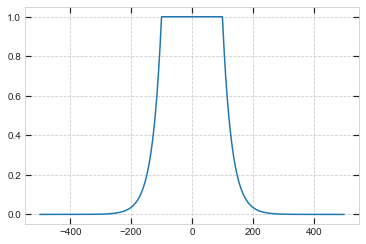

In [63]:
func = np.linspace(-500,500,999)

plt.plot(func, transfer_function(func, cutoff=100))

plt.show()

## Generating mass and size of small bodies

#### Sourced from
- Krasinsky, G.A. & Pitjev, N. & Vasilyev, Mikhail & Yagudina, Eleonora. (2002). Hidden Mass in the Asteroid Belt. Icarus. 158. 98-105. 10.1006/icar.2002.6837. doi:[10.1006/icar.2002.6837](https://doi.org/10.1006/icar.2002.6837)

For C, S and M types:
$$
\overline{\rho_{C}} = 1.38 \frac{\text{g}}{\text{cm}^{3}} = 1380 \frac{\text{kg}}{\text{m}^{3}}
$$

$$
\overline{\rho_{S}} = 2.27 \frac{\text{g}}{\text{cm}^{3}} = 2270 \frac{\text{kg}}{\text{m}^{3}}
$$

$$
\overline{\rho_{T}} = 5.32 \frac{\text{g}}{\text{cm}^{3}} = 5320 \frac{\text{kg}}{\text{m}^{3}}
$$

In [226]:
# In kg/m^3
rho_C = 1380
rho_S = 2270
rho_T = 5320

In [227]:
# Radius in meters
lowest_R = 500
highest_R = 5000

geometries = np.zeros((n_bodies, 2))

for i in range(n_bodies):
    
    radius = np.random.randint(low=lowest_R, high=highest_R)
    volume = 4/3 * radius**3 * np.pi
    mass = volume * rho_S
    
    geometries[i,0] = mass
    geometries[i,1] = radius

## Generating coordinates of small bodies

In [206]:
def sign_choose():
    return -1 if random.random() < 0.5 else 1

In [238]:
n_bodies = 1e04
coordinates = np.zeros((n_bodies, 3))

planet = 'Jupiter'
dr = 1.5
r = 3
R = Planets[planet][3] * AU_to_km
max_e = 0.4

# Focal distance of trajectories
# This is basically the central object's coordinates
obliquity = 0.2
c = obliquity * R

for i in range(n_bodies):
    # Semi-major and semi-minor axes
    # Generating perigeon distances and eccentricities
    # and calculating semi-major axis lengths using these
    # r_p = a * (1 - e^2) --> a = r_p / (1 - e^2)
    r_p = (R + 1) * r + R * np.random.rand() * dr
    e = np.random.random() * max_e
    a = r_p / (1 - e**2)
    # Calculating semi-minor axis length and eccentricity
    # c = sqrt(a^2 - b^2) |
    # e = c/a             | 
    # --> e = sqrt(1 - (b/a)^2)
    # --> b = +- sqrt(a^2 * (1 - e^2))
    b = np.sqrt(a**2 * (1 - e**2))

    if i < n_bodies//2:
        x_coord = np.random.randint(a) * sign_choose()
        y_coord = b/a * np.sqrt(a**2 - x_coord**2) * sign_choose()
    else:
        y_coord = np.random.randint(b) * sign_choose()
        x_coord = a * np.sqrt(1 - (y_coord/b)**2) * sign_choose()

    coordinates[i,0] = x_coord
    coordinates[i,1] = y_coord
    coordinates[i,2] = np.random.randint(a) * 1/10 * sign_choose()

TypeError: 'float' object cannot be interpreted as an integer

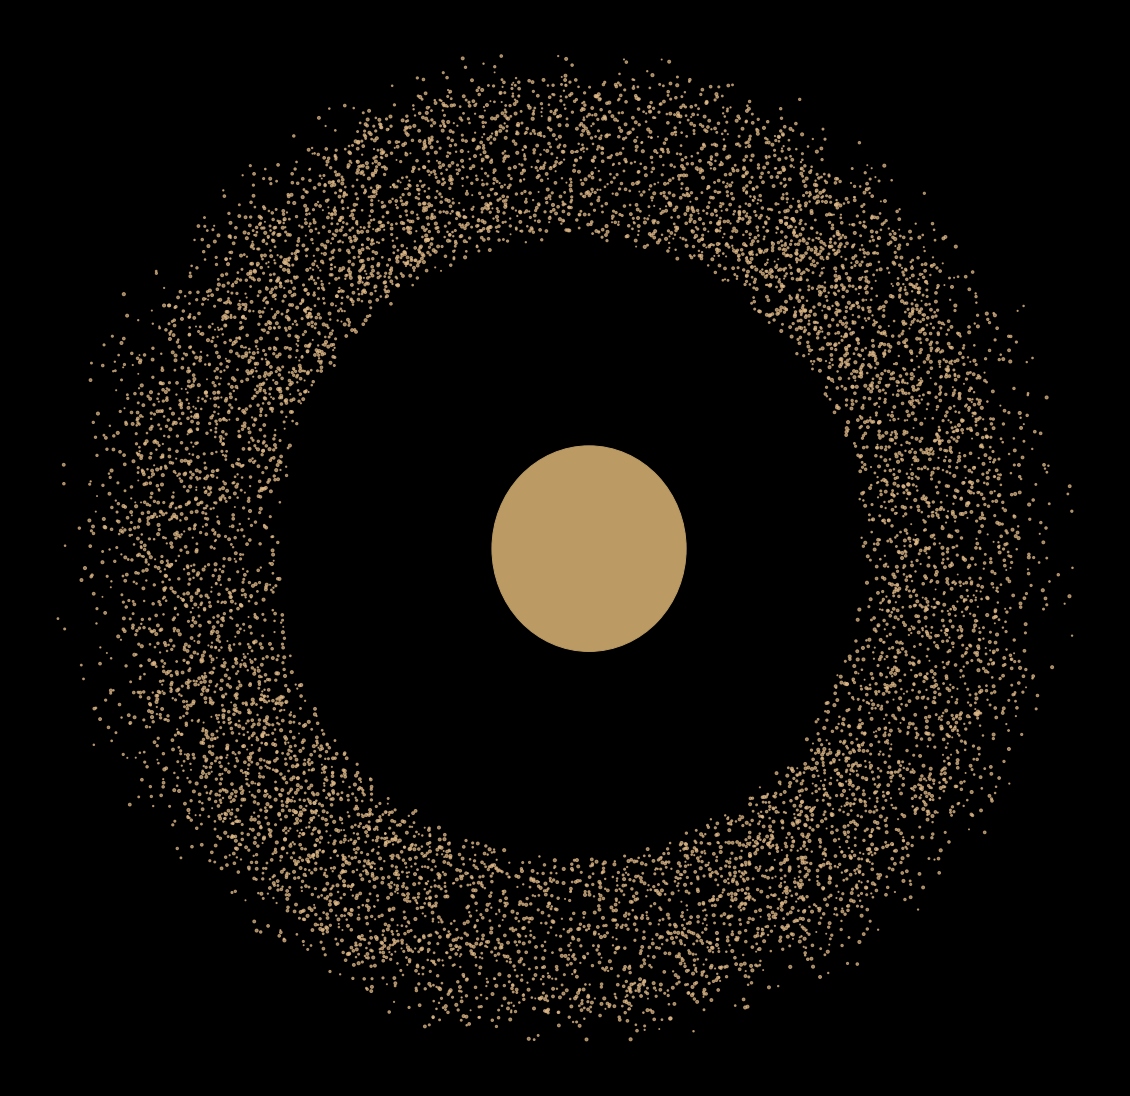

In [239]:
fig, axes = plt.subplots(figsize=(20, b/a*20), facecolor='black')
axes.set_facecolor('black')
axes.axis('off')

axes.scatter(coordinates[:,0], coordinates[:,1],
             color='burlywood', s=geometries[:,1]/lowest_R, alpha=0.7)

Planet_Pch = Circle(xy=(c,0), radius=R,
                    ec=Planet_Colors[planet], fc=Planet_Colors[planet])
axes.add_patch(Planet_Pch)

axes.set_xticks([])
axes.set_yticks([])

plt.show()

## 3D plot

In [240]:
def plot_visible(fig, x, y, z, points, azimuth, elev):
    #transform viewing angle to normal vector in data coordinates
    a = azimuth*np.pi/180. -np.pi
    e = elev*np.pi/180. - np.pi/2.
    X = [np.sin(e) * np.cos(a), np.sin(e) * np.sin(a), np.cos(e)]  
    # concatenate coordinates
    Z = np.c_[x, y, z]
    # calculate dot product 
    # the points where this is positive are to be shown
    cond = (np.dot(Z,X) >= 0)
    # filter points by the above condition
    x_c = x[cond]
    y_c = y[cond]
    z_c = z[cond]
    # set the new data points
    points.set_data(x_c, y_c)
    points.set_3d_properties(z_c, zdir="z")
    fig.canvas.draw_idle()

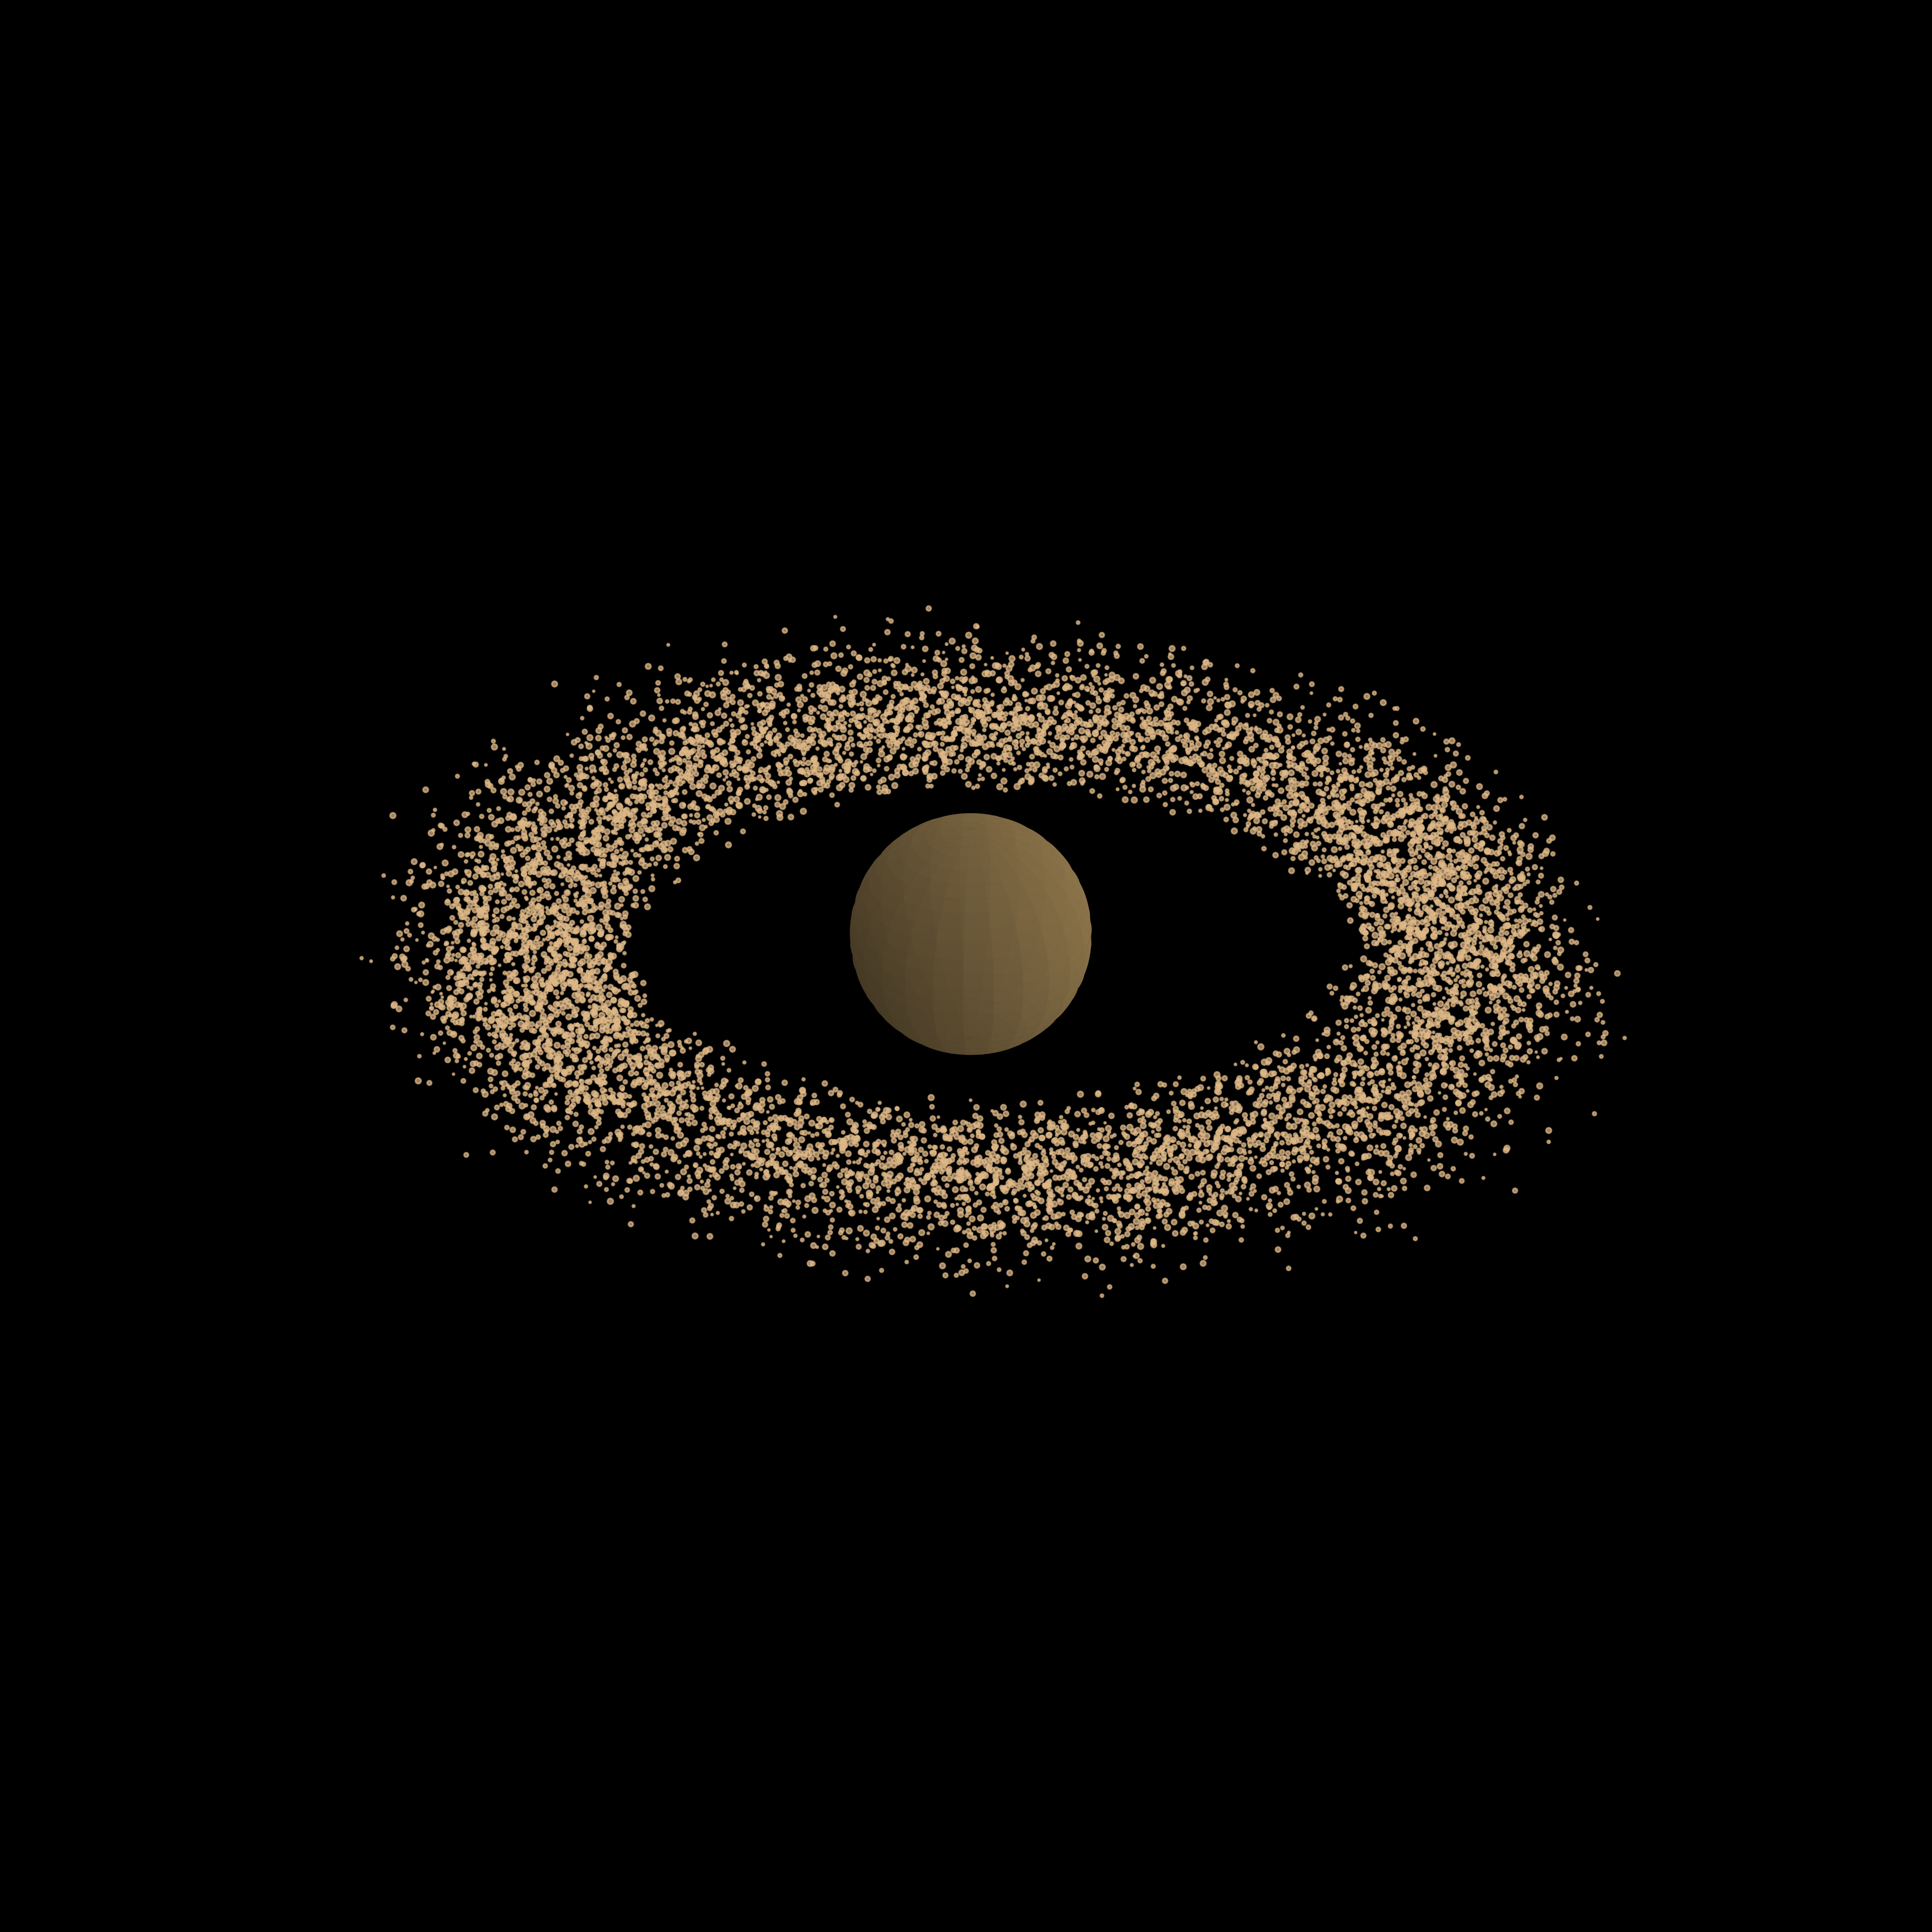

In [241]:
fig, ax = plt.subplots(figsize=(20,20), dpi=300, facecolor='black', subplot_kw={'projection' : '3d'})
ax.set_aspect('equal')

azimuth = 120
elevation = 30
ax.view_init(elevation, azimuth)
ax.set_facecolor('black')
ax.axis('off')

scale = 1.2
ax.set_xlim3d(-a*scale, a*scale)
ax.set_ylim3d(-a*scale, a*scale)
ax.set_zlim3d(-a*scale, a*scale)

ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

# Plot planet
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)

x = R * np.outer(np.cos(u), np.sin(v))
y = R * np.outer(np.sin(u), np.sin(v))
z = R * np.outer(np.ones(np.size(u)), np.cos(v))

ax.plot_surface(x+c, y, z, rstride=4, cstride=4, color=Planet_Colors[planet], linewidth=0, alpha=0.5)
ax.scatter(coordinates[:,0], coordinates[:,1], coordinates[:,2],
            edgecolor=None, color='burlywood', s=geometries[:,1]/lowest_R, alpha=0.7)
"""
# Dummy plot
points, = ax.plot([],[],[], 'k.', markersize=5, alpha=0.9)
plot_visible(fig=fig,
             x=coordinates[:,0],
             y=coordinates[:,1],
             z=coordinates[:,2],
             points=points,
             azimuth=azimuth, elev=elevation)
"""
plt.show()

## RK4

In [ ]:
//  Derivative vector for Newton's law of gravitation
cpl::Vector derivates(const cpl::Vector& x) {
    double t = x[0], r_x_Curr = x[1], r_y_Curr = x[2], v_x_Curr = x[3], v_y_Curr = x[4];

    double rSquared_1 = (r_x_Curr - CurrentCoordinates[0])*(r_x_Curr - CurrentCoordinates[0]) + (r_y_Curr - CurrentCoordinates[1])*(r_y_Curr - CurrentCoordinates[1]);
    double rSquared_2 = (r_x_Curr - CurrentCoordinates[2])*(r_x_Curr - CurrentCoordinates[2]) + (r_y_Curr - CurrentCoordinates[3])*(r_y_Curr - CurrentCoordinates[3]);

    double rCubed_1 = rSquared_1 * sqrt(rSquared_1);
    double rCubed_2 = rSquared_2 * sqrt(rSquared_2);

    cpl::Vector f(5);
    f[0] = 1;
    f[1] = v_x_Curr;
    f[2] = v_y_Curr;
    f[3] = - G * (m_temp_1 * (r_x_Curr - CurrentCoordinates[0])/rCubed_1 - m_temp_2 * (r_x_Curr - CurrentCoordinates[2])/rCubed_2);
    f[4] = - G * (m_temp_1 * (r_y_Curr - CurrentCoordinates[1])/rCubed_1 - m_temp_2 * (r_y_Curr - CurrentCoordinates[3])/rCubed_2);

    // Relativistic effects for Keplerian orbit, due to special relativity
    if(relat) {
        double gamma_x = sqrt(1 - pow(v_x_Curr, 2)/pow(c, 2));
        double gamma_y = sqrt(1 - pow(v_y_Curr, 2)/pow(c, 2));
        f[3] /= gamma_x;
        f[4] /= gamma_y;
    }
    if(switch_t_with_y) {
        //  use y as independent variable
        for(int i = 0; i < 5; i++) {
            f[i] /= v_y_Curr;
        }
    }
    return f;
}

In [237]:
coordinates

array([[ 102962.        , -271506.27992851,   -7553.4       ],
       [-158188.        ,  226150.79034793,  -11906.6       ],
       [-163594.        ,  236724.47990517,   -3247.2       ],
       ...,
       [ 142054.84927575,  188516.        ,   -6480.        ],
       [-210721.36461883, -102306.        ,   22076.8       ],
       [ 141382.99899623,  202627.        ,   22474.        ]])

In [ ]:
def sum_j(coord, axis):
    
    for idx, j in enumerate(coordinates[:, ax]):
        r_cube = coordinates[j, :] - 
        geometries[idx, 0] / r_cube * (coord - j)
    
    return

In [13]:
def derivates(X):
    
    t = X[0]; r_x = X[1]; r_y = X[2]; v_x = X[3]; v_y = X[4]
    
    # Create placeholder array to store output of the RK4 step
    # f = [t, r_x, r_y, v_x, v_y]
    f = np.zeros(5)
    
    # a_i = -G * sum_j {m_j / |r_i - r_j|^3 * (r_i - r_j)}
    # d(t)/dt = 1
    f[0] = 1
    # d(r_x)/dt = v_x
    f[1] = v_x
    # d(r_y)/dt = v_y
    f[2] = v_y
    # d(v_x) = a_x
    f[3] = - G * sum_j(r_x, axis='x')
    # d(v_y)/dt = a_y
    f[4] = - G * sum_j(r_y, axis='y')
    
    return f

In [12]:
def RK4_step(X, dt):
    k1 = dt * derivates(X)
    k2 = dt * derivates(X + 0.5 * k1)
    k3 = dt * derivates(X + 0.5 * k2)
    k4 = dt * derivates(X + k3)

    dX = (k1 + 2 * k2 + 2 * k3 + k4) / 6.0

    return dX